### Accuracy Assessment
Created by Amos Bennett.<br>
Last Updated 30 Sep 20. <br>

__Updates:__ 

Calculates the accuracy matrix (crosstab matrix) of the dNBR layer for burn severity (classes: unburnt, low, moderate, high, extreme) and burn extent (classes: unburnt, burnt). Histogram shows class separability for the burn severity analysis. By selecting breaks between classes with minimal overlap, the best accuracy result can be assessed for this particular classification. Actual and classified severities are then mapped against each other (per row) and a cross tabulation calculation is conducted.

In [146]:
import geopandas as gpd
import pandas as pd
from matplotlib import pyplot as plt

In [147]:
gdf = gpd.read_file("./training_accuracy_data.shp")
gdf = gdf.rename(columns={"Tumbarumba": "dNBR", "SEVERITY": "actual_severity"})
gdf.head()

,dNBR,actual_severity,geometry
0,-0.04120,Unburnt,POINT (620890.643 5981712.721)
1,0.58526,Moderate,POINT (584229.417 5980124.584)
2,0.20552,Low,POINT (585809.421 5980766.175)
3,0.31326,Moderate,POINT (623375.568 6070297.326)
4,0.00954,Unburnt,POINT (619427.841 6050698.299)


__From dNBR raster histogram:__<br>
mix value = -0.78936<br>
max value = 1.2721

Separate each class into separate geodataframes based on the actual (measured) classes:

In [148]:
actual_unburnt = gdf.loc[(gdf["actual_severity"] == "Unburnt")]
actual_low = gdf.loc[(gdf["actual_severity"] == "Low")]
actual_moderate = gdf.loc[(gdf["actual_severity"] == "Moderate")]
actual_high = gdf.loc[(gdf["actual_severity"] == "High")]
actual_extreme = gdf.loc[(gdf["actual_severity"] == "Extreme")]

Plot the classes (less unburnt) on a histogram to find threshold values for separation:

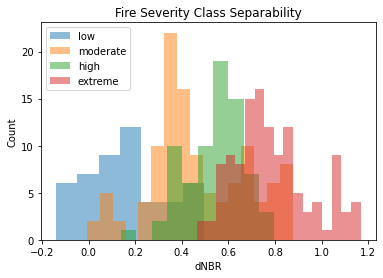

In [149]:
# plt.hist(actual_unburnt['dNBR'], bins=30, alpha = 0.5, label='unburnt')
plt.hist(actual_low["dNBR"], bins=7, alpha=0.5, label="low")
plt.hist(actual_moderate["dNBR"], bins=16, alpha=0.5, label="moderate")
plt.hist(actual_high["dNBR"], bins=10, alpha=0.5, label="high")
plt.hist(actual_extreme["dNBR"], bins=17, alpha=0.5, label="extreme")

plt.legend(loc="upper left")

plt.xlabel("dNBR")
plt.ylabel("Count")
plt.title("Fire Severity Class Separability")

plt.savefig("class_separability_severity.png")
plt.show()

Extremely poor separability between classes. This could be due to the accuracy data that was sourced by visually intepreting 3m resolution Planet Dove data using false colour cues. It was easy to identify 'extreme' classes that were completed charred and also unburnt healthy areas but distinguishing between low, moderate and high was very difficult.

Apply threshold values and map the categorical matches to the original geodataframe:

In [150]:
classified_unburnt = gdf.loc[(gdf["dNBR"] < 0.10)]
classified_low = gdf.loc[(gdf["dNBR"] >= 0.10) & (gdf["dNBR"] < 0.30)]
classified_moderate = gdf.loc[(gdf["dNBR"] >= 0.30) & (gdf["dNBR"] < 0.50)]
classified_high = gdf.loc[(gdf["dNBR"] >= 0.50) & (gdf["dNBR"] < 0.65)]
classified_extreme = gdf.loc[(gdf["dNBR"] >= 0.65)]

In [151]:
classified_unburnt = classified_unburnt.assign(classified_severity="Unburnt")
classified_low = classified_low.assign(classified_severity="Low")
classified_moderate = classified_moderate.assign(classified_severity="Moderate")
classified_high = classified_high.assign(classified_severity="High")
classified_extreme = classified_extreme.assign(classified_severity="Extreme")

Combined the results into a new geodataframe and produce a crosstab (accuracy matrix):

In [152]:
frames = [
    classified_unburnt,
    classified_low,
    classified_moderate,
    classified_high,
    classified_extreme,
]
results = pd.concat(frames)
results = results[["dNBR", "actual_severity", "classified_severity", "geometry"]]
results_duplicate = results  # used later on
results.head()

,dNBR,actual_severity,classified_severity,geometry
0,-0.04120,Unburnt,Unburnt,POINT (620890.643 5981712.721)
4,0.00954,Unburnt,Unburnt,POINT (619427.841 6050698.299)
6,-0.05770,Unburnt,Unburnt,POINT (618872.144 5981099.339)
7,-0.14799,Unburnt,Unburnt,POINT (614146.389 6011331.299)
10,-0.07889,Unburnt,Unburnt,POINT (613935.682 6011263.956)


In [153]:
xtab = pd.crosstab(results["actual_severity"], results["classified_severity"])
sev = ["Unburnt", "Low", "Moderate", "High", "Extreme"]

xtab = xtab.reindex(sev, axis="columns")
xtab = xtab.reindex(sev, axis="rows")
xtab.to_csv("./dNBR_accuracy.csv")
# xtab.to_excel('./dNBR_accuracy.xlsx')
xtab

classified_severity,Unburnt,Low,Moderate,High,Extreme
actual_severity,,,,,
Unburnt,674,45,25,4,0
Low,16,20,12,0,0
Moderate,7,11,54,12,29
High,0,2,22,35,14
Extreme,0,0,2,21,99


In [154]:
overall_accuracy = (
    (
        xtab["Unburnt"]["Unburnt"]
        + xtab["Low"]["Low"]
        + xtab["Moderate"]["Moderate"]
        + xtab["High"]["High"]
        + xtab["Extreme"]["Extreme"]
    )
    / len(gdf)
    * 100
)

overall_accuracy

79.8913043478261

In [155]:
gdf.groupby("actual_severity").count()

,dNBR,geometry
actual_severity,,
Extreme,122,122
High,73,73
Low,48,48
Moderate,113,113
Unburnt,748,748


#### Discussion
There is a disproportionally high number of unburnt sample points which have likely skewed the results to be very high. We only need to look at the count to see that unburnt samples make up a majority of the points. Let's see what happens if only 40 points from each class are randomly sampled.

In [156]:
unburnt = results.loc[(gdf["actual_severity"] == "Unburnt")]
unburnt = unburnt.sample(n=40)

low = results.loc[(gdf["actual_severity"] == "Low")]
low = low.sample(n=40)

moderate = results.loc[(gdf["actual_severity"] == "Moderate")]
moderate = moderate.sample(n=40)

high = results.loc[(gdf["actual_severity"] == "High")]
high = high.sample(n=40)

extreme = results.loc[(gdf["actual_severity"] == "Extreme")]
extreme = extreme.sample(n=40)

In [157]:
frames = [unburnt, low, moderate, high, extreme]
results = pd.concat(frames)
results = results[["dNBR", "actual_severity", "classified_severity", "geometry"]]
results.head()

,dNBR,actual_severity,classified_severity,geometry
481,-0.01858,Unburnt,Unburnt,POINT (621628.484 6080145.215)
80,-0.05860,Unburnt,Unburnt,POINT (614714.971 6012086.729)
196,-0.09548,Unburnt,Unburnt,POINT (613771.619 6011629.151)
203,-0.04435,Unburnt,Unburnt,POINT (619162.754 5980542.105)
744,-0.10348,Unburnt,Unburnt,POINT (614392.658 6067824.307)


In [158]:
xtab = pd.crosstab(results["actual_severity"], results["classified_severity"])
sev = ["Unburnt", "Low", "Moderate", "High", "Extreme"]

xtab = xtab.reindex(sev, axis="columns")
xtab = xtab.reindex(sev, axis="rows")
xtab

classified_severity,Unburnt,Low,Moderate,High,Extreme
actual_severity,,,,,
Unburnt,33,2,5,0,0
Low,15,17,8,0,0
Moderate,2,0,23,5,10
High,0,1,11,21,7
Extreme,0,0,0,8,32


In [159]:
overall_accuracy = (
    (
        xtab["Unburnt"]["Unburnt"]
        + xtab["Low"]["Low"]
        + xtab["Moderate"]["Moderate"]
        + xtab["High"]["High"]
        + xtab["Extreme"]["Extreme"]
    )
    / len(results)
    * 100
)

overall_accuracy

63.0

This is likely a far more accurate representation of the overall accuracy of this classification. This is still not based considering the very minimal processing overhead for a dNBR compared to a multi-band fully connected neural network approach. Unfortunately, with each different location, scene, weather conditions (pre/post), vegetation ecosystems etc; there is significant variability that the chose threshold values would need to be tweaked to suit each scene. This is where a majority of the time would be spent, and normalising severity from one scene to another become very difficult as moderate in one may not neccessarily map well to moderate in another location with a completely different ecosystem of flora.

Lets look at the accuracy if the only two endmembers were 'Unburnt' or 'Burnt' areas. In order to do this, we re-map low, moderate, high and extreme categorisations in the actual and classified severity columns to 'burnt' and reproduce the crosstab.

In [160]:
results_duplicate.loc[
    results_duplicate.actual_severity == "Low", "actual_severity"
] = "Burnt"
results_duplicate.loc[
    results_duplicate.actual_severity == "Moderate", "actual_severity"
] = "Burnt"
results_duplicate.loc[
    results_duplicate.actual_severity == "High", "actual_severity"
] = "Burnt"
results_duplicate.loc[
    results_duplicate.actual_severity == "Extreme", "actual_severity"
] = "Burnt"
results_duplicate.loc[
    results_duplicate.classified_severity == "Low", "classified_severity"
] = "Burnt"
results_duplicate.loc[
    results_duplicate.classified_severity == "Moderate", "classified_severity"
] = "Burnt"
results_duplicate.loc[
    results_duplicate.classified_severity == "High", "classified_severity"
] = "Burnt"
results_duplicate.loc[
    results_duplicate.classified_severity == "Extreme", "classified_severity"
] = "Burnt"

In [161]:
results_duplicate.head()

,dNBR,actual_severity,classified_severity,geometry
0,-0.04120,Unburnt,Unburnt,POINT (620890.643 5981712.721)
4,0.00954,Unburnt,Unburnt,POINT (619427.841 6050698.299)
6,-0.05770,Unburnt,Unburnt,POINT (618872.144 5981099.339)
7,-0.14799,Unburnt,Unburnt,POINT (614146.389 6011331.299)
10,-0.07889,Unburnt,Unburnt,POINT (613935.682 6011263.956)


In [162]:
unburnt = results_duplicate.loc[(results_duplicate["actual_severity"] == "Unburnt")]
unburnt = unburnt.sample(n=160)

burnt = results_duplicate.loc[(results_duplicate["actual_severity"] == "Burnt")]
burnt = burnt.sample(n=160)

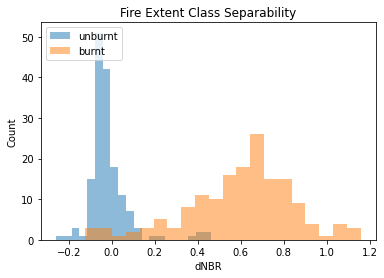

In [163]:
plt.hist(unburnt["dNBR"], bins=20, alpha=0.5, label="unburnt")
plt.hist(burnt["dNBR"], bins=20, alpha=0.5, label="burnt")

plt.legend(loc="upper left")

plt.xlabel("dNBR")
plt.ylabel("Count")
plt.title("Fire Extent Class Separability")

plt.savefig("class_separability_extent.png")
plt.show()

In [164]:
frames = [unburnt, burnt]
results = pd.concat(frames)
results = results[["dNBR", "actual_severity", "classified_severity", "geometry"]]
results.head()

,dNBR,actual_severity,classified_severity,geometry
270,0.10231,Unburnt,Burnt,POINT (619750.767 6050983.635)
229,0.41480,Unburnt,Burnt,POINT (624291.845 6054611.124)
632,0.04088,Unburnt,Unburnt,POINT (619508.579 6051545.459)
1100,-0.06627,Unburnt,Unburnt,POINT (618908.834 5981071.124)
890,0.00235,Unburnt,Unburnt,POINT (619425.089 6050590.772)


In [165]:
xtab = pd.crosstab(results["actual_severity"], results["classified_severity"])
sev = ["Unburnt", "Burnt"]

xtab = xtab.reindex(sev, axis="columns")
xtab = xtab.reindex(sev, axis="rows")
xtab

classified_severity,Unburnt,Burnt
actual_severity,,
Unburnt,150,10
Burnt,8,152


In [166]:
overall_accuracy = (
    (xtab["Unburnt"]["Unburnt"] + xtab["Burnt"]["Burnt"]) / len(results) * 100
)

overall_accuracy

94.375

Overall, the accuracy of the dNBR in identifying between unburnt and burnt areas is approximately 90%. This is very high and a decent result for the identification of burn area extent or boundaries. A good way to really test this however would be to sample many points across known boundary areas in order to determine if the same accuracy still holds.